##**Alunos:**

Lucas Barbosa dos Santos - lbs@cesar.school

Luis Erani Mendes Carneiro Viniski - Lemcv@cesar.school

Gabriel Ximenes Bezerra Carrazoni - gxbc@cesar.school

In [1195]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [1196]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/homer_bart_1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1197]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1198]:
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [1199]:
class ImageDataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.transform = transform
        self.images = []
        self.labels = []

        # Carregar as imagens e rótulos
        for filename in os.listdir(self.file_path):
            if filename.endswith(".bmp"):
                img_path = os.path.join(self.file_path, filename)
                img = Image.open(img_path)

                # Redimensionar para 64x64
                img = img.resize((64, 64))

                # Convertendo para um array numpy e normalizando
                img = np.array(img) / 255.0  # Normaliza para intervalo [0, 1]

                # Flatten a imagem
                img = img.flatten()  # Transforma a imagem 64x64 em um vetor de 4096

                # Rótulos baseados no nome do arquivo
                if "homer" in filename.lower():
                    label = 0  # Homer
                elif "bart" in filename.lower():
                    label = 1  # Bart

                self.images.append(img)
                self.labels.append(label)

        # Converter para arrays numpy
        self.images = np.array(self.images)
        self.labels = np.array(self.labels)

        # Dividir os dados em treino e teste
        self.train_images, self.test_images, self.train_labels, self.test_labels = train_test_split(
            self.images, self.labels, test_size=0.3, random_state=42
        )

    def __len__(self):
        return len(self.train_images)

    def __getitem__(self, idx):
        image = torch.tensor(self.train_images[idx], dtype=torch.float32)
        label = torch.tensor(self.train_labels[idx], dtype=torch.long)
        return image, label

In [1200]:
# Preparar o DataLoader
train_dataset = ImageDataset(file_path='/content/drive/My Drive/Colab Notebooks/homer_bart_1')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Dividir os dados para validação
test_images = torch.tensor(train_dataset.test_images, dtype=torch.float32)
test_labels = torch.tensor(train_dataset.test_labels, dtype=torch.long)

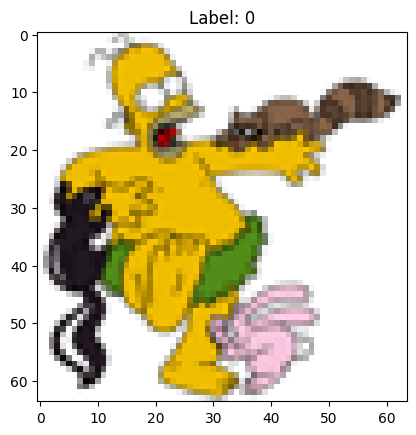

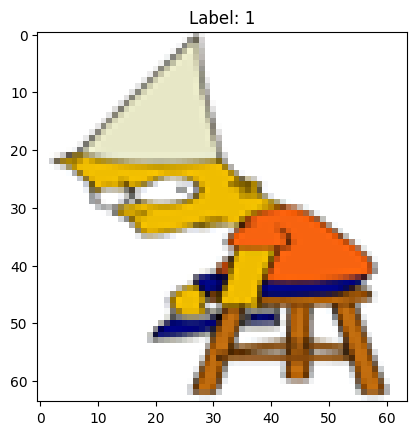

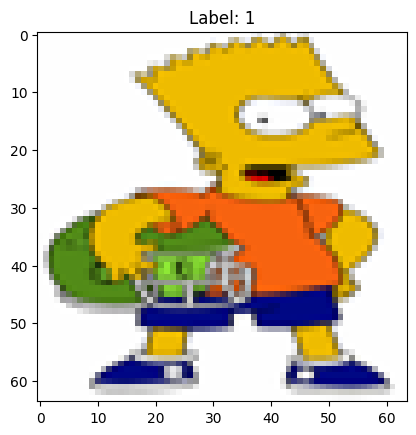

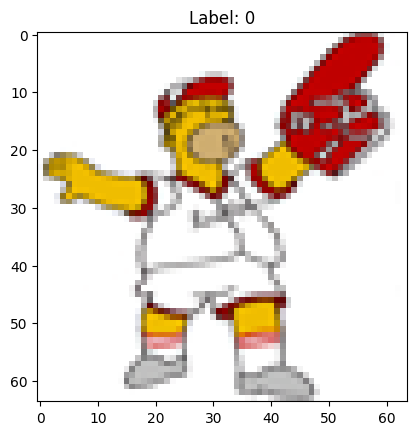

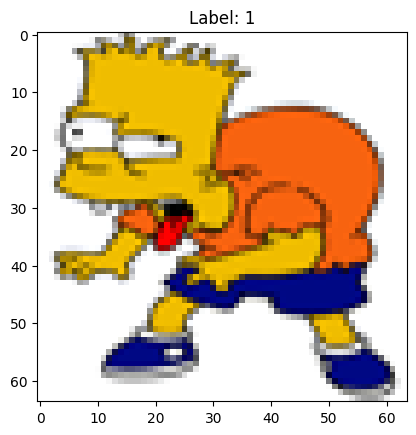

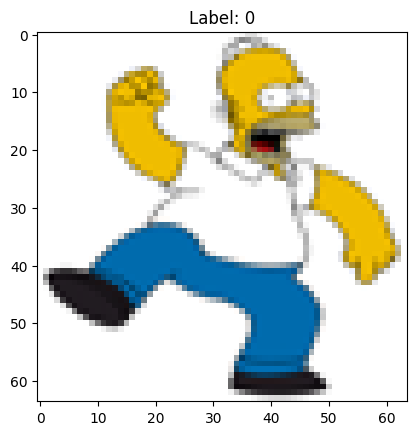

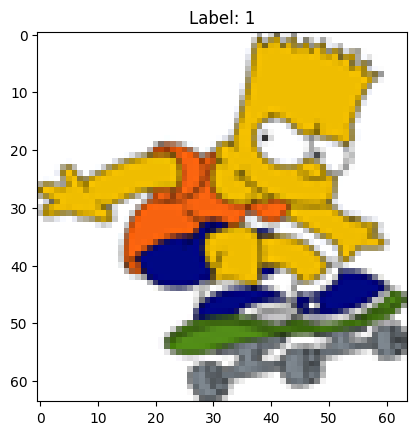

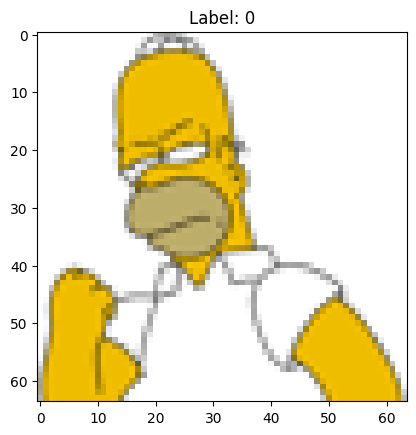

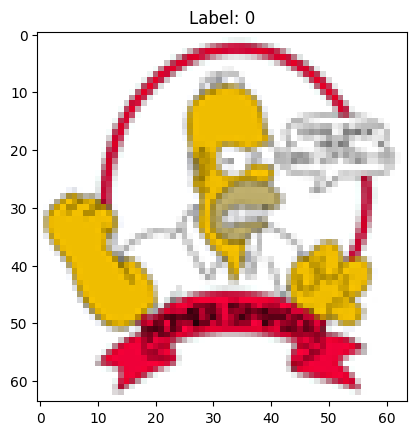

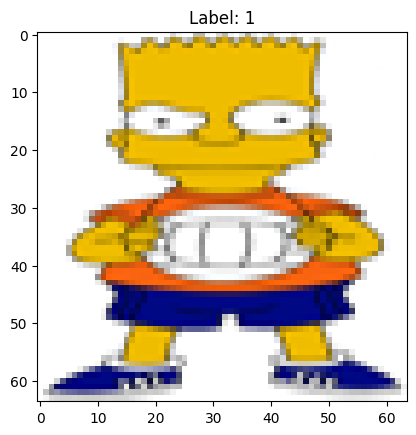

In [1201]:
# Obtendo o primeiro batch de imagens e rótulos do DataLoader
data_iter = iter(train_loader)  # Cria um iterador para percorrer o DataLoader
images, labels = next(data_iter)  # Obtém o primeiro batch de imagens e rótulos

# As imagens estão em um tensor, precisamos converter para numpy e garantir que o formato esteja certo
# Exibindo as 10 primeiras imagens do batch
for i in range(10):
    img = images[i].numpy()  # Convertendo para numpy

    # Redimensiona de volta para 64x64x3
    img = img.reshape(64, 64,3)  # As imagens foram flatten, então devemos redimensionar para (64, 64,3)

    # Exibindo a imagem
    plt.imshow(img)
    plt.title(f'Label: {labels[i].item()}')  # Exibindo o rótulo como título (0 = Homer, 1 = Bart)
    plt.show()


In [1202]:
#Criação da classe:
class HomerBartNet(nn.Module):
    def __init__(self):
        super(HomerBartNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(64*64*3, 512),
            nn.ReLU(),
            nn.Linear(512, 2))   # Saída: 2 classes (Homer ou Bart)


    def forward(self, x):
        return self.net(x)

In [1203]:
model = HomerBartNet()

In [1204]:
# Pegando os primeiros 5 exemplos
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Apenas os 5 primeiros
xin = images[:5]
labels = labels[:5]

# Flatten as imagens (de (5, 3, 64, 64) para (5, 12288))
xin = xin.view(-1, 64*64*3)

# (Opcional) mover para o mesmo device do modelo
xin = xin.to(device)
labels = labels.to(device)
model = model.to(device)

# Forward pass
score = model(xin)

# Resultado bruto (logits)
print("Score bruto:", score)

# Classe prevista
_, predicted = torch.max(score, 1)
print("Classes previstas:", predicted)
print("Classes reais:    ", labels)

Score bruto: tensor([[-0.4119,  0.1220],
        [-0.2685, -0.0087],
        [-0.2056,  0.0714],
        [-0.1351,  0.0420],
        [-0.2753,  0.0931]], grad_fn=<AddmmBackward0>)
Classes previstas: tensor([1, 1, 1, 1, 1])
Classes reais:     tensor([0, 1, 0, 0, 0])


In [1205]:
# Definindo perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

In [1206]:
# Treinar por N épocas
num_epochs = 30
train_accuracies = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # As imagens estão flatten? Se não, fazemos isso aqui
        if images.ndim > 2:
            images = images.view(images.size(0), -1)  # (batch_size, 12288)

        # Zerar gradientes
        optimizer.zero_grad()

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # Estatísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)
    train_losses.append(running_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/30], Loss: 86.7527, Accuracy: 43.62%
Epoch [2/30], Loss: 26.1097, Accuracy: 45.74%
Epoch [3/30], Loss: 13.6364, Accuracy: 46.81%
Epoch [4/30], Loss: 8.0231, Accuracy: 61.70%
Epoch [5/30], Loss: 7.4241, Accuracy: 69.15%
Epoch [6/30], Loss: 5.8884, Accuracy: 76.60%
Epoch [7/30], Loss: 5.3936, Accuracy: 79.79%
Epoch [8/30], Loss: 5.7172, Accuracy: 76.60%
Epoch [9/30], Loss: 5.4917, Accuracy: 78.19%
Epoch [10/30], Loss: 5.4207, Accuracy: 80.32%
Epoch [11/30], Loss: 5.2371, Accuracy: 78.72%
Epoch [12/30], Loss: 4.9622, Accuracy: 83.51%
Epoch [13/30], Loss: 4.5782, Accuracy: 86.17%
Epoch [14/30], Loss: 4.6818, Accuracy: 79.79%
Epoch [15/30], Loss: 4.8600, Accuracy: 81.38%
Epoch [16/30], Loss: 4.5974, Accuracy: 85.64%
Epoch [17/30], Loss: 4.1608, Accuracy: 84.04%
Epoch [18/30], Loss: 3.8581, Accuracy: 88.30%
Epoch [19/30], Loss: 3.6250, Accuracy: 89.36%
Epoch [20/30], Loss: 3.6272, Accuracy: 86.17%
Epoch [21/30], Loss: 2.8861, Accuracy: 92.55%
Epoch [22/30], Loss: 3.3053, Accuracy: 8

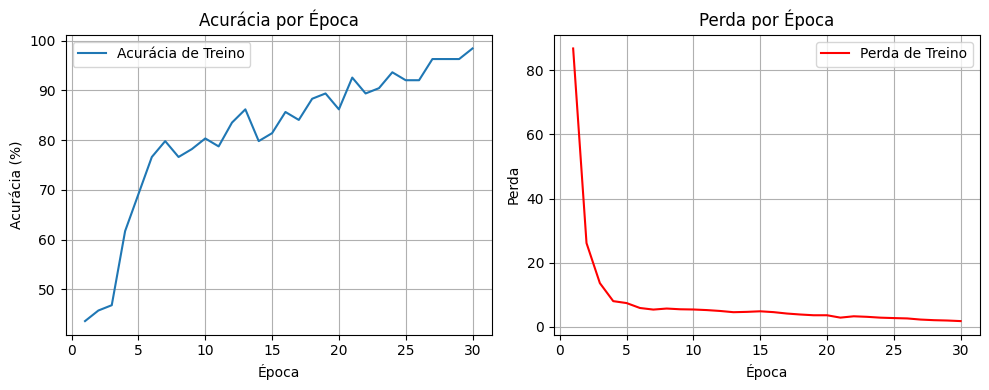

In [1207]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))

# Gráfico de acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Acurácia de Treino')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.grid(True)
plt.legend()

# Gráfico de perda
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, color='red', label='Perda de Treino')
plt.title('Perda por Época')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [1208]:
val_dataset = TensorDataset(test_images, test_labels)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [1209]:
model.eval()  # Coloca o modelo em modo de avaliação
val_correct = 0
val_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        # Achate as imagens se estiver usando um modelo sem convolução
        images = images.view(images.size(0), -1)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_accuracy = 100 * val_correct / val_total
print(f'Val Accuracy: {val_accuracy:.2f}%')


Val Accuracy: 72.84%


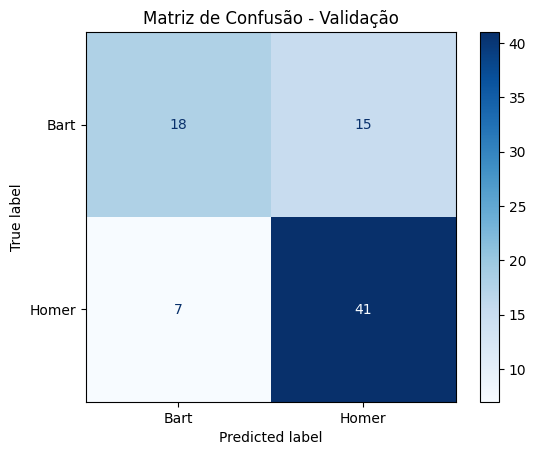

In [1210]:
cm = confusion_matrix(all_labels, all_preds)
class_names = ['Bart', 'Homer']  # Ou ajuste conforme sua label

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Validação")
plt.show()

##**Conclusão**

O modelo desenvolvido apresentou um desempenho promissor na tarefa de classificação entre as imagens de Homer e Bart, alcançando uma acurácia de validação de 72,84%. A rede neural simples, composta por uma camadas com ativação ReLU e regularização via weight decay, foi capaz de aprender características relevantes dos dados, conforme evidenciado pela acurácia de treino elevada (~95%) e a redução consistente da perda ao longo das épocas. A matriz de confusão indicou que a classe Homer foi melhor classificada em comparação com a classe Bart, que apresentou maior taxa de confusão, possivelmente devido ao desequilíbrio ou características visuais semelhantes entre as classes.

Entretanto, apesar do bom desempenho, observou-se uma diferença considerável entre a acurácia de treino e validação, sugerindo um leve overfitting do modelo aos dados de treino. A oscilação na acurácia de validação e a menor performance para a classe Bart apontam para limitações relacionadas ao tamanho reduzido do dataset de apenas 269 imagens e à possível desigualdade na distribuição das classes.

Para melhorar os resultados, recomenda-se ampliar o conjunto de dados, especialmente aumentando a quantidade de imagens da classe Bart, o que pode contribuir para um aprendizado mais equilibrado. Além disso, a implementação de técnicas de aumento de dados (data augmentation) pode ajudar a criar maior diversidade e robustez no treinamento. Por fim, testar funções de ativação alternativas, como LeakyReLU ou ELU, e ajustar parâmetros de regularização podem contribuir para reduzir o overfitting e estabilizar a acurácia de validação.

Com essas melhorias, é esperado que o modelo atinja uma acurácia mais alta e consistente, tornando-se mais confiável para a classificação das imagens entre Homer e Bart.